In [81]:
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import interp
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (auc, roc_curve, 
                             precision_recall_curve, 
                             average_precision_score)
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import StandardScaler


In [27]:
glass = pd.read_csv(r'glass.csv', sep=',')
glass.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


**1.	Изучить набор данных. Создать описание набора данных на русском языке. Описать признаки, используемые в наборе данных.**
 - RI - Показатель преломления
 - Na - Натрий (процент веса, аттрибуты от 4 до 10)
 - Mg - Магний
 - Al - Алюминий
 - Si - Кремний
 - K - Калий
 - Ca - Кальций
 - Ba - Барий
 - Fe - Железо
 - Типы стекла: 1 - термополированное строительное стекло(70), 2 - нетермополированное строительное стекло(76), 3 - термополированное автомобильное стекло(17), 4 - нетермополированное автомобильное стекло (нет в этой базе данных), 5 - контейнеры(13), 6 - посуда(9), 7 - фары(29)

In [28]:
glass.shape

(214, 10)

In [29]:
glass.count()

RI      214
Na      214
Mg      214
Al      214
Si      214
K       214
Ca      214
Ba      214
Fe      214
Type    214
dtype: int64

**2. Удалите дубликаты строк в наборе данных.**

In [30]:
glass = glass.drop_duplicates()
glass.shape

(213, 10)

In [31]:
glass.count()

RI      213
Na      213
Mg      213
Al      213
Si      213
K       213
Ca      213
Ba      213
Fe      213
Type    213
dtype: int64

** 3. Оцените сбалансированность данных по классам (постройте гистограмму). Используйте полученную информацию при выборе метрики оценки качества классификации (PR или ROC кривая). **

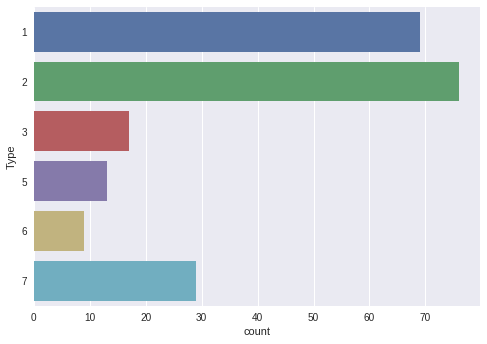

In [32]:
sns.countplot(data=glass, y='Type')
plt.show()

Соотношение количество элементов заметно отличается, поэтому будем считать, что классы несбалансированы.
Будем использовать ROC-кривую, поскольку она дает адекватную оценку качества работы алгоритма, где классы несбалансированы и их размеры выборки отличаются друг от друга несущественно (не на порядок)

** 4. Выполните масштабирование количественных признаков. ** 

In [33]:
numerical_columns = [i for i in glass.columns if glass[i].dtype.name != 'object']
categorial_columns = [i for i in glass.columns if glass[i].dtype.name == 'object']

print('numerical: ', numerical_columns)
print('categorial: ', categorial_columns)

numerical:  ['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe', 'Type']
categorial:  []


** 5. Выполните замену категориальных признаков. **
 - Type, по сути, является категориальным признаком, т.к. числовое значение просто соответствует названию, но у нас он уже представлен количественным.

** 6. Оцените корреляцию между признаков. **

In [34]:
glass_corr = glass.drop('Type', axis=1).corr()
sns.heatmap(df_corr)
plt.show()

NameError: name 'df_corr' is not defined

In [35]:
glass_corr

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
RI,1.000000,-0.198802,-0.127526,-0.400973,-0.539000,-0.287645,0.811183,0.001679,0.147083
Na,-0.198802,1.000000,-0.278420,0.167735,-0.064885,-0.264158,-0.278194,0.329080,-0.239374
Mg,-0.127526,-0.278420,1.000000,-0.479575,-0.162437,0.007617,-0.446197,-0.491818,0.085426
Al,-0.400973,0.167735,-0.479575,1.000000,-0.016195,0.323683,-0.258068,0.480642,-0.080583
Si,-0.539000,-0.064885,-0.162437,-0.016195,1.000000,-0.197281,-0.207145,-0.104389,-0.097717
K,-0.287645,-0.264158,0.007617,0.323683,-0.197281,1.000000,-0.317032,-0.043653,-0.009372
Ca,0.811183,-0.278194,-0.446197,-0.258068,-0.207145,-0.317032,1.000000,-0.112208,0.126314
Ba,0.001679,0.329080,-0.491818,0.480642,-0.104389,-0.043653,-0.112208,1.000000,-0.059729
Fe,0.147083,-0.239374,0.085426,-0.080583,-0.097717,-0.009372,0.126314,-0.059729,1.000000


Видна сильная положительная зависимость между пропускной способности и кальцием, отрицательная с алюминием и кремнием, слабая с остальными

** 7. Заполните пропущенные значения в данных. **

In [36]:
glass.shape

(213, 10)

In [37]:
glass.count()

RI      213
Na      213
Mg      213
Al      213
Si      213
K       213
Ca      213
Ba      213
Fe      213
Type    213
dtype: int64

Пропусков нет

** 8. Решите поставленную задачу классификации в соответствии с заданием. **
- классификатор K ближайших соседей (задаётся радиус для выбора ближайших объектов)
- логический классификатор (бинарное решающее дерево)

In [70]:
# разделим полученные данные на данные для обучения и теста
X, y = glass.drop('Type', axis=1), glass['Type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

print(X_train.shape)
print(X_test.shape)

(149, 9)
(64, 9)


In [71]:
# найдем оптимальный радиус для классификатора ближайших соседей
rnc = RadiusNeighborsClassifier(outlier_label=1)

params = {'radius': np.arange(0, 2, 0.1)}

rnc_grid = GridSearchCV(rnc, params)
rnc_grid.fit(X_train, y_train)

best_radius = rnc_grid.best_estimator_.radius
best_score = rnc_grid.best_score_
print('best train score:', best_score, '\t at radius:', best_radius)

rnc = RadiusNeighborsClassifier(outlier_label=7, radius=best_radius)
rnc.fit(X_train, y_train)
best_score  = np.mean(y_test  == rnc.predict(X_test))
print('test score: ', best_score)

best train score: 0.5704697986577181 	 at radius: 1.8
test score:  0.625


In [72]:
#найдем оптимальные глубину и количества учитываемых параметров для классификатора решающее дерево
dtc = DecisionTreeClassifier()

params = {'max_depth': list(range(1,10)), 'max_features': list(range(1,10))}

dtc_grid = GridSearchCV(dtc, params)
dtc_grid.fit(X_train, y_train)

best_features = dtc_grid.best_estimator_.max_features
best_depth = dtc_grid.best_estimator_.max_depth
best_score = dtc_grid.best_score_
print('best train score:', best_score, 
      '\t at features number:', best_features,
      '\t at depth:', best_depth)

dtc = DecisionTreeClassifier(max_depth=best_depth, max_features=best_features)
dtc.fit(X_train, y_train)
best_score  = np.mean(y_test == dtc.predict(X_test))
print('test score: ', best_score)

best train score: 0.6845637583892618 	 at features number: 6 	 at depth: 6
test score:  0.625


Для построения ROC кривой необходимо получить вероятности принадлежности примера к одному из классов, а затем варьировать границу выбора класса. Вероятности можно получить с помощью метода predict_proba. Но, к сожалению, этот метод отсутствует у классификатора RadiusNeighborsClassifier. Остается только попытаться написать его аналог.

In [73]:
y_test = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6])

In [74]:
class MyRadiusNeighborsClassifier(RadiusNeighborsClassifier):
        
    def predict_proba(self, X_test, X_train, y_train):
        '''
        
        General description. 
        Determines the probability that a test instance matching a class.
        
        Algorithm. 
        We'll go through the zero radius to the double classifier radius
        with the elementary step(dr). If an instance lies along the:
        * Zero raduis+dr - corresponds 100%
        * Classifier raduis+dr - corresponds 50%
        * Double classifier raduis+dr and beyond it - corresponds 0%
        There are intermediate values of percents. Each step corresponds
        to its own percentage value. If predicted instance changes its 
        class, this instance belongs to the current radius and it is 
        assigned the appropriate percentage. 
        
        fit method built-in
        '''
        runs = 25
        dr = (2*self.radius/runs)    
        
        radiuses = [dr*i for i in range(runs)]  
        percentage = [i/runs for i in range(runs)]
        percentage = sorted(percentage, reverse=True)
        probas = np.ndarray((len(y_test),7), dtype=np.float)
        for i in range(len(probas)):
            probas[i] = [0, 1, 2, 3, 4, 5, 6]
        
        for i, radius in enumerate(radiuses):
            if i==0:
                rnc_temp = RadiusNeighborsClassifier(radius, outlier_label=1)
                predict_first = rnc_temp.fit(X_train, y_train).predict(X_test)
                continue
            else:
                predict_second = predict_first
                rnc_tmp = RadiusNeighborsClassifier(radius, outlier_label=1)
                predict_first = rnc_tmp.fit(X_train, y_train).predict(X_test)
        
            for j, (p1, p2) in enumerate(zip(predict_first, predict_second)):
                if p1!=p2:
                    probas[j,0] = percentage[i]
                    probas[j,1] = 1-probas[j,0]
                
        return probas

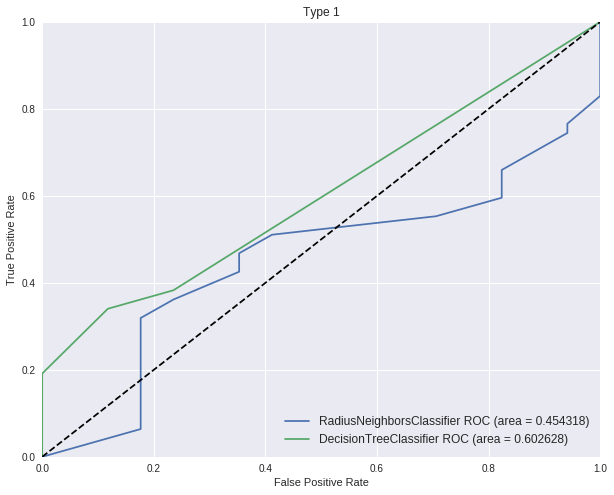

In [86]:
# ROC
plt.figure(figsize=(10,8))
mrnc = MyRadiusNeighborsClassifier(outlier_label=7, radius=best_radius)
probas_mrnc0 = mrnc.predict_proba(X_test, X_train, y_train)
tpr, fpr, thresholds = roc_curve(y_test[:,1], probas_mrnc0[:,1])
roc_auc  = auc(fpr, tpr)
plt.plot(fpr, tpr, label='%s ROC (area = %f)' % ('RadiusNeighborsClassifier', roc_auc)) 

dtc = DecisionTreeClassifier(max_depth=best_depth, max_features=best_features)
probas_dtc0 = dtc.fit(X_train, y_train).predict_proba(X_test)
tpr, fpr, thresholds = roc_curve(y_test[:,1], probas_dtc0[:,1])
roc_auc  = auc(fpr, tpr)
plt.plot(fpr, tpr, label='%s ROC (area = %f)' % ('DecisionTreeClassifier', roc_auc))   

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4, fontsize='medium')
plt.title('Type 1')
plt.show()

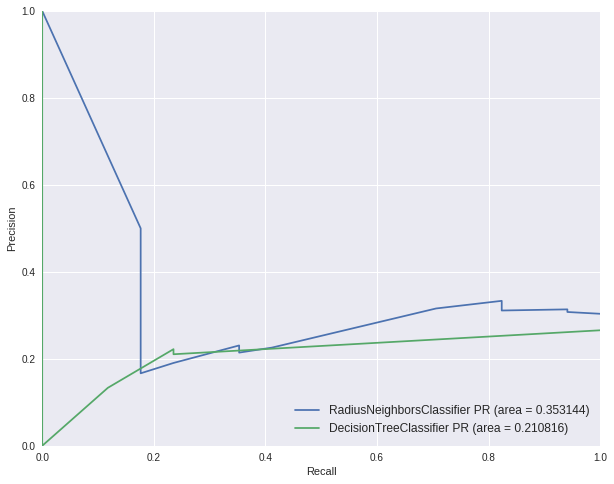

In [87]:
# PR
plt.figure(figsize=(10,8))
precision, recall, thresholds = precision_recall_curve(y_test[:,1], probas_mrnc1[:,1])
aps_mrnc1 = average_precision_score(y_test[:,1],probas_mrnc1[:,1])
plt.plot(recall, precision, label='%s PR (area = %f)' % ('RadiusNeighborsClassifier', aps_mrnc1)) 

precision, recall, thresholds = precision_recall_curve(y_test[:,1], probas_dtc1[:,1])
aps_dtc1 = average_precision_score(y_test[:,1],probas_dtc1[:,1])
plt.plot(recall, precision, label='%s PR (area = %f)' % ('DecisionTreeClassifier',  aps_dtc1)) 

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc=4, fontsize='medium')
plt.show()

**9. Сравните кривые для классификаторов, указанных в задании, сделайте вывод **
* Классификаторы дерево принятия решений и k ближайших соседей(по радиусу) имеют примерно одинаковые показатели качества относительно ROC кривой. В целом, данные классификаторы слабо решают задачу предсказания класса с вероятностью ~0.45-0.6, но и лучше от случайного - 0.17 (т.к. классов всего 6). Поэтому задача классификации была решена, но по-прежнему есть пути улучшить результаты: подобрать более подходящий под задачу классификатор, осуществить несколько иной подход к подготовке данных в соответсвие с выбранным классификатором.